<div align="center">
<h1>Loop Q Prize</h1>
<h2 >Challenge A</h2>
    <h3>Solution by Alexandros P. Pouroullis</h3>
<div>

<h1>Loading the data</h1>

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import os
import pandas as pd
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import glob
from IPython.display import Audio
import random

from sklearn.preprocessing import LabelEncoder

In [64]:
train_audio_path = "./challengeA_data/train"
train_csv_path = "./challengeA_data/2022challengeA_train.csv"
test_audio_path = "./challengeA_data/test"
test_csv_path = "./challengeA_data/2022challengeA_test.csv"

In [65]:
train_df = pd.read_csv(train_csv_path, index_col=[0])
test_df = pd.read_csv(test_csv_path, index_col=[0])

train_df.head()

,file_id,emotion,origin
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,fear,crema
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,fear,crema
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,sadness,crema
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,disgust,crema
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,neutral,crema


In [4]:
test_df.head()

,file_id,origin,predicted_emotion
0,030472df-9d70-4d76-a1a5-acb4c33537d3.wav,crema,NaN
1,ac4720de-e0d9-4667-86a7-4236d410ed25.wav,crema,NaN
2,264928af-cb15-4125-abf7-9408369d83b2.wav,crema,NaN
3,2233ce2b-35ae-483c-9397-1058f681b6ef.wav,crema,NaN
4,472aa1eb-b4dc-452c-84b7-934ed61285da.wav,crema,NaN


<h1>Data Preparation</h1>

In [5]:
train_df.isnull().sum()

file_id    0
emotion    1
origin     0
dtype: int64

In [605]:
# Checking if there is a mismatch of files in the train metadata dataframe and the dataset directory
file_ids_set = set(train_df["file_id"])
audio_files_list = glob.glob(os.path.join(train_audio_path, "*.wav"))
audio_files_list = [file.replace(train_audio_path+"/", "") for file in audio_files_list]
audio_files_set = set(audio_files_list)

files_diff_file_ids = file_ids_set.difference(audio_files_set)
files_diff_audio_files = audio_files_set.difference(file_ids_set)
print("Number of file ids present in the training metadata dataframe not present in the training dataset:", len(files_diff_file_ids))
print("Number of audio file names present in the training dataset not present in the training metadata dataframe:", len(files_diff_audio_files))

Number of file ids present in the training metadata dataframe not present in the training dataset: 1
Number of audio file names present in the training dataset not present in the training metadata dataframe: 0


One file is missing a label and the training metadata dataframe contains one file id that isn't present in the training dataset. I'll find the indexes in the training metadata dataframe of these two occurrences and remove them.

In [606]:
missing_file = list(files_diff_file_ids)[0]
print("Index of instance with missing emotion:")
print(train_df[train_df.isnull().any(axis=1)].index[0])
print()
print("Index of instance with file id not present in training dataset:")
print(train_df.loc[train_df["file_id"] == missing_file].index[0])

Index of instance with missing emotion:
8937

Index of instance with file id not present in training dataset:
8937


It appears that the record with the missing label is also the instance with the file id that isn't present in the training dataset. I'll remove this record from the dataframe.

In [607]:
print("Number of instances before removal:", len(train_df.index))

for missing_file in missing_training_files:
    missing_file_index = train_df.loc[train_df["file_id"] == missing_file].index
    train_df.drop(index=missing_file_index, axis=0, inplace=True)

print("Number of instances after removal:", len(train_df.index))

Number of instances before removal: 10111
Number of instances after removal: 10110


We can see that the instance was successfully removed from the dataframe. I'll reset the indexes of the training metadata dataframe because the removed instance leaves a gap in the indexes.

In [608]:
train_df.reset_index(drop=True, inplace=True)

In [609]:
train_df.isnull().sum()

file_id    0
emotion    0
origin     0
dtype: int64

And to verify that what I did worked, I printed the counts of null values in the dataframe; it indeed worked.

I want to get the class distribution for the emotions. One way to go about doing this is simply to group the dataframe by emotion and get the counts for each emotion, but this wouldn't tell us the full story if the sound files are of varying duration, because sound files of a greater duration provide more information in training. I'll first check if the duration of files vary. If this is the case, then I will get the mean duration for each emotion and plot the distribution. The distribution is important, because if there is a substantial imbalance in the representations of emotions, the model will be biased towards those emotions that it saw more of. Thus, it will need to be addressed later on in the preprocessing phase, where I'd likely use something like data augmentation to add more instances to the underrepresented emotions.

In [611]:
# Displaying the durations of a random sample of 10 audio files.
print("Durations of a random sample of 10 audio files:")
print("-"*40)
for audio_file_name in train_df.sample(n=10)["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        # Specifying None for sr uses the native sample rate of the audio file, which in this case
        # is 16kHz.
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        print("{0:.2f}s".format(duration))
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")


Durations of a random sample of 10 audio files:
----------------------------------------
3.27s
2.54s
3.87s
1.87s
1.83s
2.94s
2.34s
2.42s
2.60s
2.40s


The durations of the audio files do indeed vary. I'll append a column specifying the duration of the audio files in the training metadata dataframe so I can get the mean duration of the audio files for each emotion.

In [612]:
duration_column = pd.Series([], dtype="float64")
for audio_file_name in train_df["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        duration_column = pd.concat([duration_column, pd.Series(duration, dtype="float64")], ignore_index=True)
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")
        
duration_column = duration_column.rename("duration")
duration_column


0        2.669313
1        2.569250
2        2.902875
3        2.035375
4        2.268937
           ...   
10105    1.969649
10106    1.311911
10107    2.402720
10108    1.933972
10109    2.178873
Name: duration, Length: 10110, dtype: float64

In [613]:
train_df = pd.concat([train_df, duration_column.rename("duration")], axis=1, )
train_df

,file_id,emotion,origin,duration
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,fear,crema,2.669313
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,fear,crema,2.569250
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,sadness,crema,2.902875
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,disgust,crema,2.035375
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,neutral,crema,2.268937
...,...,...,...,...
10105,78c8debb-0538-4d48-a3f8-0a33b5978e42.wav,surprise,tess,1.969649
10106,2636304a-47c8-486e-a43b-6ac16ecf5798.wav,fear,tess,1.311911
10107,b9291006-74b0-43dc-bea1-8a6a1527ccdb.wav,disgust,tess,2.402720
10108,de13c5a0-6a9a-4287-a0c8-f0183d1783a3.wav,happy,tess,1.933972


Just so that I don't have to compute the durations of each audio file again, I'll save the above dataframe as a different csv file in the path *./challengeA_data/* with the name *2022challengeA_train_with_durations.csv*.

In [614]:
train_df.to_csv("./challengeA_data/2022challengeA_train_with_durations.csv")

I can then load the csv file again like so:

In [66]:
train_df = pd.read_csv("./challengeA_data/2022challengeA_train_with_durations.csv", index_col=[0])

In [ ]:
# Getting the sample rates of each audio file
sample_rate_column = pd.Series([], dtype="float64")
for audio_file_name in train_df["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        sample_rate_column = pd.concat([sample_rate_column, pd.Series(sample_rate, dtype="float64")], ignore_index=True)
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")
        
sample_rate_column = sample_rate_column.rename("duration")

In [731]:
print("Sample rates used by the audio files:", ', '.join([str(round(sr))+'hz' for sr in sorted(sample_rate_column.unique())]))

Sample rates used by the audio files: 16000hz, 24414hz, 44100hz, 48000hz


It also appears that the sample rates of the sound files vary, presumably, by origin.<br>
<br>
The highest frequency speech usually reaches is about 4kHz. And, as per the <a href="https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem">Nyquist-Shannon sampling theorem</a>, the sampling rate should be double the highest frequency of a sound to be able to sufficiently capture the detail of a sound, which should be intuitive, because a sample rate double the maximum frequency is the minimum requirement to capture both the trough and peak of a cycle. Thus, in the preprocessing phase, I'll downsample the audio files with higher frequency rates to the minimum frequency rate (16kHz), and no loss of important information should occur.

I'll now get the representations of each emotion in the dataset by using the mean durations of each emotion.

In [484]:
emotion_distribution = train_df.groupby("emotion")["duration"].mean()
# Just capitalizing the labels
emotion_distribution.index = [index.capitalize() for index in emotion_distribution.index]

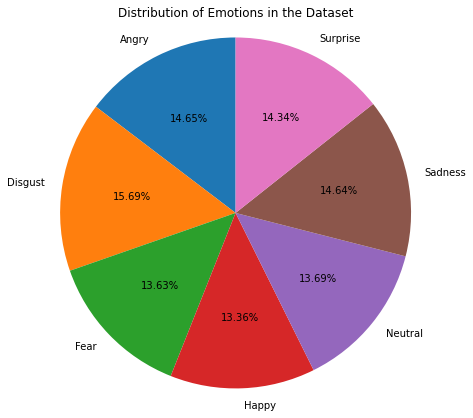

In [732]:
colors = sns.color_palette("tab10", n_colors=10)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Distribution of Emotions in the Dataset")
ax.pie(emotion_distribution, labels=emotion_distribution.index, autopct="%.2f%%", 
       colors=colors[:len(emotion_distribution)], startangle=90)
# Set the aspect ratio to be equal so that the pie chart is drawn as a circle
ax.axis("equal");


In [486]:
train_df["emotion"].value_counts()

angry       1652
happy       1634
disgust     1629
fear        1628
sadness     1555
neutral     1452
surprise     560
Name: emotion, dtype: int64

An interesting discovery made from the above demonstration was that although the number of occurrences of surprise was roughly a 3rd of the number of occurrences of other emotions, the distribution of emotions in terms of duration was roughly uniform. Thus, there's no class imbalance to be addressed.

<h1>Visualising audio</h1>

In [100]:
# Play a 'random' audio file
random_instance = train_df.iloc[7970]
random_audio_file = os.path.join(train_audio_path,random_instance["file_id"])
emotion = random_instance["emotion"]
print("Emotion:", emotion)
Audio(random_audio_file)

Emotion: angry


There are a variety of ways to visualize audio. The simplest is plotting amplitude against time, which I do below.

Sample rate: 24414hz
5 random samples: 0.11282349, -0.06350708, -0.008148193, 0.03768921, -0.0014648438
Audio file duration: 2.32s
Emotion: angry


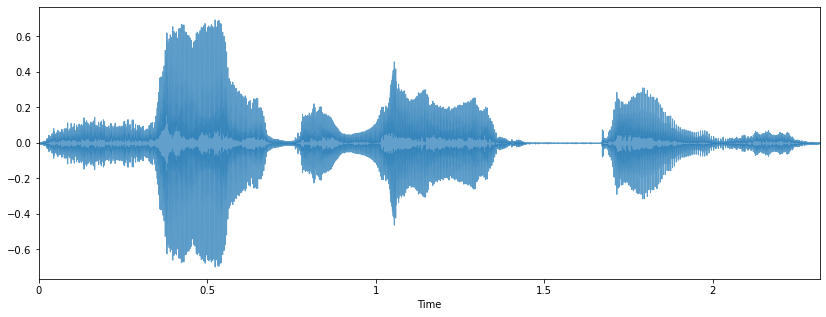

In [101]:
plt.figure(figsize=(14, 5))
samples, sample_rate = librosa.load(random_audio_file, sr=None)   
duration_of_file = random_instance["duration"]

print(f"Sample rate: {sample_rate}hz")
print("5 random samples:", ', '.join([str(choice) for choice in random.choices(samples, k=5)]))
print("Audio file duration: {0:.2f}s".format(duration_of_file))
print(f"Emotion: {emotion}")

plt.xlim([0, duration_of_file])
librosa.display.waveshow(samples, sr=sample_rate, alpha=0.7);

Audio is stored on a computer as a discrete time series of amplitudes, called samples. The sample rate represents how many samples are captured per second. Each sample stores only an amplitude – there's no indication of time; the specific time of a sample can be computed by using the index of the sample and multiplying it by the period of a sample which is the inverse of the sample rate (<font size=3>$\frac{1}{sample\ rate}$</font>). 

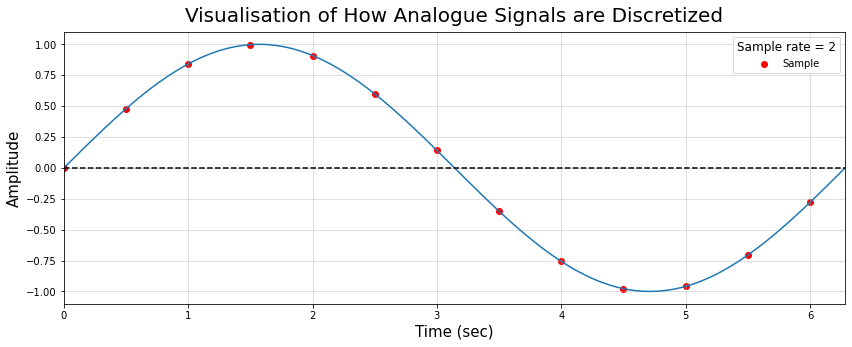

In [710]:
# Plotting a sine wave with samples superimposed on it.
def plot_sin_wave(A=1, freq=1, phase=0, num_cycles=1):
    STEP_SIZE = 0.05
    start = 0 + phase
    period = (2*np.pi)/freq
    stop = num_cycles*period
    
    x = np.arange(start, stop+STEP_SIZE, STEP_SIZE)
    y = A*np.sin(freq*x + phase)
    
    plt.plot(x, y)
    plt.axhline(y=0, color="k", ls='--')
    plt.grid(True, which="both", alpha=0.5)
    plt.xlim([0, stop])


def plot_samples(start, stop, sample_rate):
    sample_period = 1/sample_rate
    x = np.arange(start, stop+sample_period, sample_period)
    y = np.sin(freq*x)
    plt.scatter(x, y, color="r", label=f"Sample")
    plt.legend(title=f"Sample rate = {sample_rate}").get_title().set_fontsize(12)


A = 1
freq = 1
phase = 0
num_cycles = 1
period = (2*np.pi)/freq
start = 0 + phase
stop = num_cycles*period
sample_rate = 2

plt.figure(figsize=(14, 5))
plot_sin_wave(A=A, freq=freq, phase=phase, num_cycles=num_cycles) 
plot_samples(start, stop, sample_rate)
plt.xlabel("Time (sec)", fontsize=15)
plt.ylabel("Amplitude", fontsize=15)
plt.title("Visualisation of How Analogue Signals are Discretized", pad=10, fontsize=20);

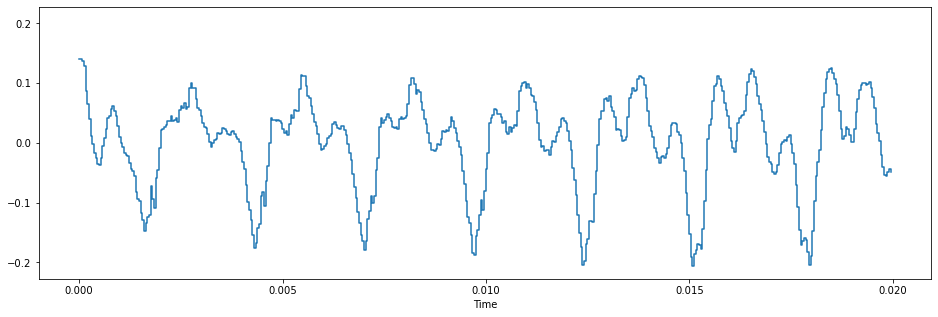

In [101]:
# Zooming into the audio file, displaying 500 random consecutive samples.
freq_start = 20000
duration_in_sec = 0.02
duration_in_samples = int(duration_in_sec*sample_rate)
freq_stop = freq_start + duration
sample_of_signal = samples[freq_start:freq_stop]
plt.figure(figsize=(16, 5))
librosa.display.waveshow(sample_of_signal, sr=sample_rate);

We can see in above display that the audio file looks like a highly complex waveform. What if we could break it up so that it was instead a sum of periodic functions that are easily definable, like sinusoids? Fortunately we can *(hint: using the discrete Fourier transform)*! The discrete Fourier transform (DFT) transforms a wave from the time domain to the frequency domain, such that the amplitude of each frequency in the DFT is proportional to the **average** presence of the sinusoidal wave of that frequency in the composition of the original wave. The DFT produces a complex number $c=a+bj$, which can be represented as a point on the complex plane with angle $arg(c)$ ($arg(c)=arctan(\frac{b}{a})$) – phase, and magnitude $abs(c)$ ($abs(c)=\sqrt{Re(c)^2+Im(c)^2}$) – amplitude. Because in our case we only care about the magnitude of the frequencies in their contribution to the signal, we only use the magnitude when plotting the Fourier transform.

<h1>Fourier transform</h1>

In [130]:
def plot_fft(signal, sr, title):
    """
    Plots the discrete FFT for freq_ratio of the sample rate.
    """
    ft = np.fft.fft(signal)
    magnitude = np.abs(ft)
    
    frequency = np.linspace(0, sr, len(signal))
    
    plt.figure(figsize=(16, 5))
    plt.plot(frequency, magnitude)
    plt.xlabel("Frequency (hz)")
    plt.xticks(np.arange(min(frequency), max(frequency)+1, 250))
    plt.xlim([0, max(frequency)//4])
    plt.title(title)

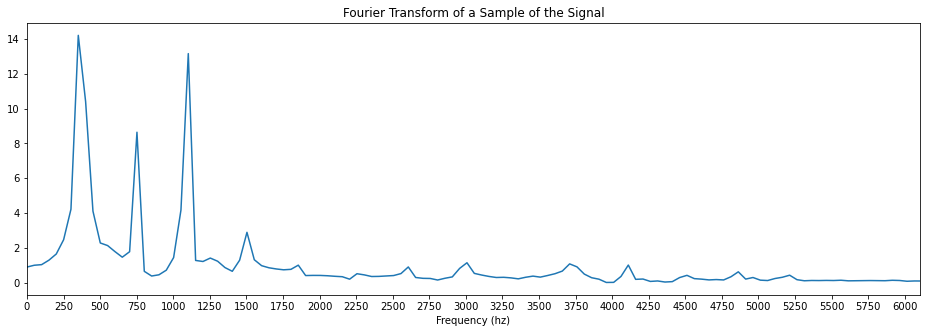

In [131]:
plot_fft(sample_of_signal, sample_rate, "Fourier Transform of a Sample of the Signal")

And *voila*! Our plot also confirms that the frequencies most present in speech are indeed below ~4000hz.

As a fun experiment, I use the data above to create an approximation of the sample of the signal.

In [15]:
def freq_to_angular(freq):
    return (2*np.pi)*freq

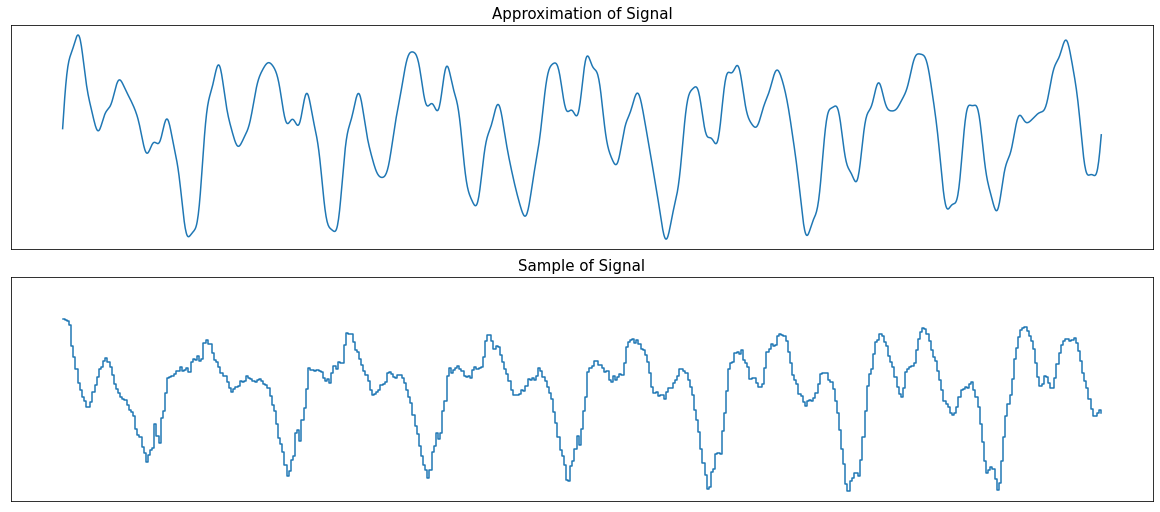

In [124]:
plt.figure(figsize=(16, 7), constrained_layout=True)

time = np.arange(0, duration_in_sec, 0.00001)

phase = 0
# sin 1
omega = freq_to_angular(325)
y1 = 14*np.sin(omega*time + phase)

# sin 2
omega = freq_to_angular(750)
y2 = 8.2*np.sin(omega*time + phase)

# sin 3
omega = freq_to_angular(1100)
y3 = 13.5*np.sin(omega*time + phase)

# sin 4
omega = freq_to_angular(1500)
y4 = 3*np.sin(omega*time + phase)

# sin 5
omega = freq_to_angular(3000)
y5 = np.sin(omega*time + phase)

# sin 6
omega = freq_to_angular(3700)
y6 = np.sin(omega*time + phase)

# sin 7
omega = freq_to_angular(4100)
y7 = np.sin(omega*time + phase)


combined_signal = y1+y2+y3+y4+y5+y6+y7

plt.subplot(2, 1, 1)
plt.title("Approximation of Signal", fontsize=15)
plt.plot(time, combined_signal)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 1, 2)
plt.title("Sample of Signal", fontsize=15)
librosa.display.waveshow(sample_of_signal);
plt.xticks([])
plt.yticks([])
plt.xlabel("");

The only issue with the Fourier transform is that it gives us the frequency components of the signal overall. But we want to know how the frequency content of the sound changes through time. So what do we do? Well, we just compute snapshots of the DFT at regular, short intervals, using what's called the short-time Fourier transform (STFT). The matrix the STFT produces, where rows represent frequency bins (because computers can't compute the magnitude of sinusoid for every $f$ where $f\in\mathbb{R}$) and columns represent uniformly-sized time frames, is called the spectrogram and gives us a very neat, compact representation of the frequency content of a signal through time, thus capturing all the information we set out to gather.

<h1>Spectrogram</h1>

In [102]:
# n_fft of 512 is ideal for speech. It must be a power of 2 to improve the speed of the fast fourier transform.
n_fft = 512
hop_length = n_fft // 4
specgram = librosa.stft(samples, n_fft=512, hop_length=hop_length)

# Take only the magnitudes of the frequencies
specgram = np.abs(specgram)

In [103]:
specgram.shape

(257, 442)

The shape of the spectrogram indicates that it captured the magnitudes of 257 frequency bins in 1640 time frames.

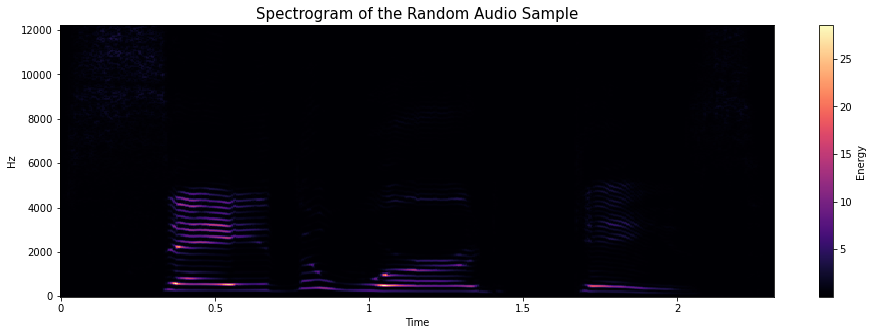

In [104]:
plt.figure(figsize=(16, 5))
# specgram needs to take in the hop length so that it can compute the correct time on the x-axis.
librosa.display.specshow(specgram, sr=sample_rate, x_axis="time", y_axis="linear", hop_length=hop_length);
plt.colorbar().ax.set_ylabel("Energy");
plt.title("Spectrogram of the Random Audio Sample", fontsize=15);

The spectrogram is plotted, but it gives us a rather disappointing result. There is only some indication of energy in the lower frequencies, but it's very faint. <br>
<br>
The reason this is the case is because the range of sound intensities in nature is *extremely* large. And yet we are still able to perceive sounds at two extremes such that they aren't that distant. This is because we perceive sound logarithmically. That's why sound intensity is often converted to the logarithmic scale, measured in decibels (dB), where each increase in 10 decibels represents a sound-energy ten times larger, beginning from some reference point – usually the threshold of hearing.

In [117]:
# Converting the amplitudes/energies to the decibel scale
specgram = librosa.amplitude_to_db(specgram)
specgram.shape

(257, 442)

Note that the shape of the *db* ndarray is the same as the *specgram* ndarray.

Now, let's see what happens when we plot it.

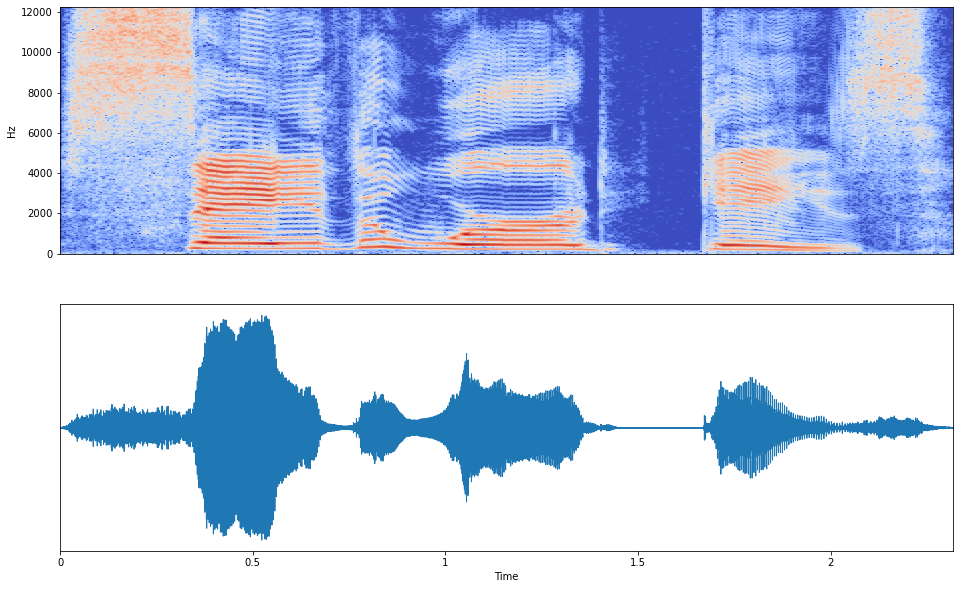

In [106]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
librosa.display.specshow(db, sr=sample_rate, y_axis="linear", hop_length=hop_length);

plt.subplot(2, 1, 2)
librosa.display.waveshow(samples, sr=sample_rate, x_axis="time");
plt.xlim([0, duration_of_file])
plt.yticks([]);

What's really awesome about the spectrogram is we can visualise where certain sounds occur and how high/low they were. For example, in the first 0.25 seconds, the person in the audio sample uses a hard 's' sound, which can be seen in the upper frequencies at the beginning of the spectrogram.

<h1>How humans perceive frequency</h1>

We've come very far, but there's still one more thing to address. Humans don't perceive sound linearly: differences between lower frequencies are more perceptible than differences between higher frequencies. I'll demonstrate this.

In [24]:
# Playing a 100hz sine wave for 2 seconds followed by a 200hz sine wave for 2 seconds
sr = 4.41e4
sample_duration = 1/sr

freq1 = 100
freq2 = 200
duration = 2
time = np.linspace(0, duration, int(sr*duration))
sound1 = np.sin(time*freq_to_angular(freq1))
sound2 = np.sin(time*freq_to_angular(freq2))
combined_sound = np.concatenate([sound1, sound2])
Audio(combined_sound, rate=sr)

In [59]:
def play_two_sines(freq1, freq2):
    sr = 4.41e4
    duration = 2
    
    time = np.linspace(0, duration, int(sr*duration))
    sound1 = 0.5*np.sin(time*freq_to_angular(freq1))
    sound2 = 0.5*np.sin(time*freq_to_angular(freq2))
    combined_sound = np.concatenate([sound1, sound2])
    
    display(Audio(combined_sound, rate=sr))

In [60]:
# Playing a 100hz sine wave for 2 seconds followed by a 200hz sine wave for 2 seconds
play_two_sines(100, 200)

In [56]:
play_two_sines(1000, 1100)

In [61]:
play_two_sines(10000, 10100)

The 100hz and 200hz sine waves are easy distinguishable; the 1000hz and 1100hz ones to a lesser extent; and the 10000hz and 10100hz barely. And, once again, this should be quite intuitive. Increasing the frequency of a 100hz wave by 100 doubles the frequency, while adding 100hz to 10000hz increases the frequency by only 1%. 

Introducing the mel-scale. The mel-scale is a scale that was determined empirically, such that equal distances on the scale have the same perceptual distance. It provides a linear auditory scale for the human auditory system. The mel-spectrogram will allow us to feed sound information to the model similar to what a human would perceive.

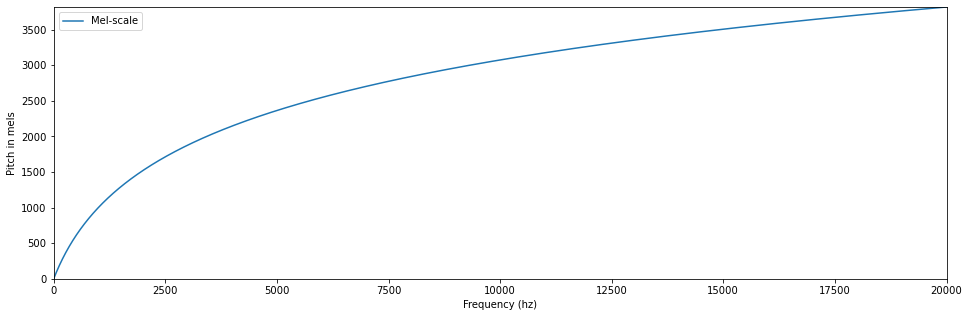

In [97]:
frequencies = np.arange(0, 20000+1, 1)
mel_frequencies = librosa.hz_to_mel(frequencies, htk=True)
plt.figure(figsize=(16, 5))
plt.plot(frequencies, mel_frequencies, label="Mel-scale")
plt.xlabel("Frequency (hz)")
plt.ylabel("Pitch in mels");
plt.xlim([0, np.max(frequencies)])
plt.ylim([0, np.max(mel_frequencies)]);
plt.legend();

As we can see, the mel-scale is logarithmic in shape. This is because pitches with higher frequencies require far larger distances from each other to be perceived as being equal in pitch distance than lower frequencies.

Now, I'll convert the vanilla spectrogram into a mel-spectrogram by applying mel-filter banks onto the spectrogram, which will yield some number *n* mel-bins which will have magnitudes associated with them, representing how present each bin is in that frame of time. What this mel-spectrogram essentially represents is how present bins of frequencies are that are perceptually equal in distance from one another.

In [150]:
mel_specgram = librosa.feature.melspectrogram(y=samples, 
                                                sr=sample_rate, 
                                                n_fft=n_fft,
                                                hop_length=hop_length, 
                                                n_mels=128) 

In [110]:
mel_specgram.shape

(128, 442)

Above, I compute the mel-spectrogram of the audio file. The number of rows represents the number of mel-bins, and the number of columns represents the number of time frames the mel-bins were computed for. <br>
The number of mel-bins selected was arbitrary; there's no one-size fits all amount, so I'll start with the standard 128 bins.

In [151]:
mel_specgram = librosa.power_to_db(mel_specgram)

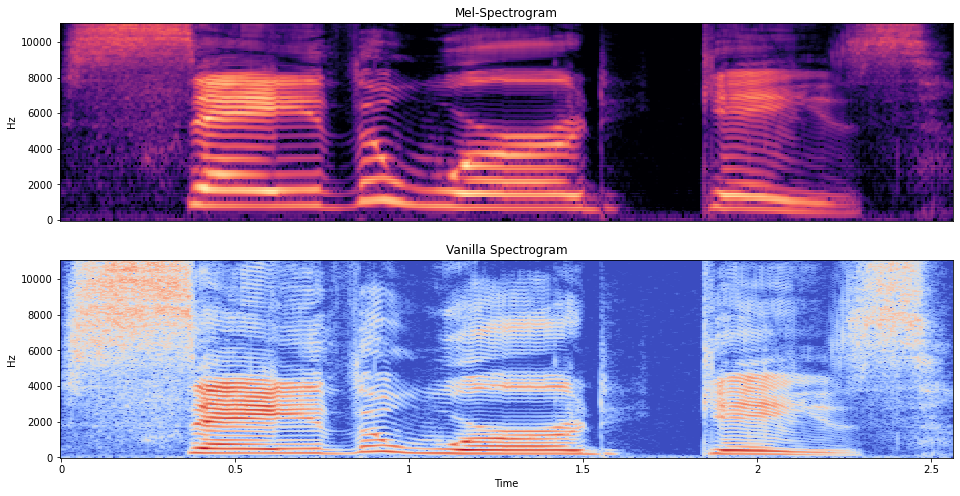

In [154]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title("Mel-Spectrogram")
librosa.display.specshow(mel_specgram, y_axis="linear", hop_length=hop_length)

plt.subplot(2, 1, 2)
plt.title("Vanilla Spectrogram")
librosa.display.specshow(specgram, y_axis="linear", x_axis="time", hop_length=hop_length);

<h1>Preparing the Audio Data<h1>

In [177]:
train_df.head()

,file_id,emotion,origin,duration
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,fear,crema,2.669313
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,fear,crema,2.569250
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,sadness,crema,2.902875
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,disgust,crema,2.035375
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,neutral,crema,2.268937


In [199]:
n_channels_column = pd.Series([], dtype=np.int16)
for file in train_df["file_id"].values:
    file_path = os.path.join(train_audio_path, file)
    samples, sr = librosa.load(file_path, sr=None)
    n_channels_column = pd.concat([n_channels_column, pd.Series(samples.ndim, dtype="int16")], ignore_index=True)

n_channels_column

0        1
1        1
2        1
3        1
4        1
        ..
10105    1
10106    1
10107    1
10108    1
10109    1
Length: 10110, dtype: int16

In [200]:
train_df["channels"] = n_channels_column

In [171]:
X = train_df["file_id"].to_numpy()
y = train_df["emotion"].to_numpy()

In [175]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.fit_transform(y)

array([2, 2, 5, ..., 1, 3, 3])

In [167]:
new_train_df = train_df[["file_id", "emotion"]]

In [168]:
new_train_df.head()

,file_id,emotion
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,fear
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,fear
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,sadness
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,disgust
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,neutral


In [169]:
new_train_df.loc[:, "emotion"] = pd.factorize(new_train_df["emotion"])[0]

<ipython-input-169-8b327c44d4f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_df.loc[:, "emotion"] = pd.factorize(new_train_df["emotion"])[0]


In [164]:
new_train_df

,file_id,emotion
0,ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav,0
1,08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav,0
2,f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav,1
3,8934caea-8409-4034-ae41-fa8552e2c3d6.wav,2
4,d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav,3
...,...,...
10105,78c8debb-0538-4d48-a3f8-0a33b5978e42.wav,6
10106,2636304a-47c8-486e-a43b-6ac16ecf5798.wav,0
10107,b9291006-74b0-43dc-bea1-8a6a1527ccdb.wav,2
10108,de13c5a0-6a9a-4287-a0c8-f0183d1783a3.wav,5
